In [1]:
import numpy as np
import pandas as pd
import os

### Data curation

In [2]:
CORRELATIONS = os.path.join("data", "correlations.csv")

df = pd.read_csv(CORRELATIONS, index_col="clip_name")
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 8064 entries, 207_id19_celeb_clip_0 to 16_id0_fake_clip_5
Columns: 436 entries, leftShoulder_X*rightShoulder_X to pristine
dtypes: float64(436)
memory usage: 26.9+ MB


,leftShoulder_X*rightShoulder_X,leftShoulder_X*leftElbow_X,leftShoulder_X*rightElbow_X,leftShoulder_X*leftWrist_X,leftShoulder_X*rightWrist_X,leftShoulder_X*leftShoulder_Y,leftShoulder_X*rightShoulder_Y,leftShoulder_X*leftElbow_Y,leftShoulder_X*rightElbow_Y,leftShoulder_X*leftWrist_Y,...,AU23_r*AU26_r,AU23_r*pose_Rx,AU23_r*pose_Rz,AU25_r*AU26_r,AU25_r*pose_Rx,AU25_r*pose_Rz,AU26_r*pose_Rx,AU26_r*pose_Rz,pose_Rx*pose_Rz,pristine
clip_name,,,,,,,,,,,,,,,,,,,,,
207_id19_celeb_clip_0,-1.0,0.896910,-0.684285,0.728418,-0.776546,0.914665,0.978394,0.220155,0.290392,0.605656,...,-0.371109,-0.084862,0.256737,0.677971,0.351435,-0.135390,0.078872,-0.074653,-0.656714,0.0
214_id20_celeb_clip_2,-1.0,0.944202,-0.994526,0.936670,-0.953693,0.986707,1.000000,0.986293,0.984946,0.997428,...,-0.384210,0.338814,-0.439432,0.674008,-0.113254,0.217822,-0.480208,0.368657,-0.628787,0.0
240_id23_celeb_clip_4,-1.0,0.833483,-0.915368,0.702566,-0.928953,0.931838,1.000000,0.953161,0.974447,0.933059,...,0.416525,-0.700947,0.005953,0.163318,0.746491,-0.427656,0.035669,-0.561861,-0.057797,0.0


In [3]:
df.fillna(0, inplace=True)

Add binary columns for classification
- Zelenskyi: idP
- DeepFake zelenskyi: idF
- 27ids: id0-id26

In [4]:
df['idP'] = df.index.str.contains("pristine").astype(int)
df['idF'] = df.index.str.contains("fake").astype(int)
for i in range(27):
    column_name = f'id{i}'
    df[column_name] = df.index.str.contains(f'id{i}') & df.index.str.contains('celeb')

In [5]:
df.head(3)

,leftShoulder_X*rightShoulder_X,leftShoulder_X*leftElbow_X,leftShoulder_X*rightElbow_X,leftShoulder_X*leftWrist_X,leftShoulder_X*rightWrist_X,leftShoulder_X*leftShoulder_Y,leftShoulder_X*rightShoulder_Y,leftShoulder_X*leftElbow_Y,leftShoulder_X*rightElbow_Y,leftShoulder_X*leftWrist_Y,...,id17,id18,id19,id20,id21,id22,id23,id24,id25,id26
clip_name,,,,,,,,,,,,,,,,,,,,,
207_id19_celeb_clip_0,-1.0,0.896910,-0.684285,0.728418,-0.776546,0.914665,0.978394,0.220155,0.290392,0.605656,...,False,False,True,False,False,False,False,False,False,False
214_id20_celeb_clip_2,-1.0,0.944202,-0.994526,0.936670,-0.953693,0.986707,1.000000,0.986293,0.984946,0.997428,...,False,False,False,True,False,False,False,False,False,False
240_id23_celeb_clip_4,-1.0,0.833483,-0.915368,0.702566,-0.928953,0.931838,1.000000,0.953161,0.974447,0.933059,...,False,False,False,False,False,False,True,False,False,False


### Data exploration

Train some model that would visualise it (PDA like), make it colourful and add labels

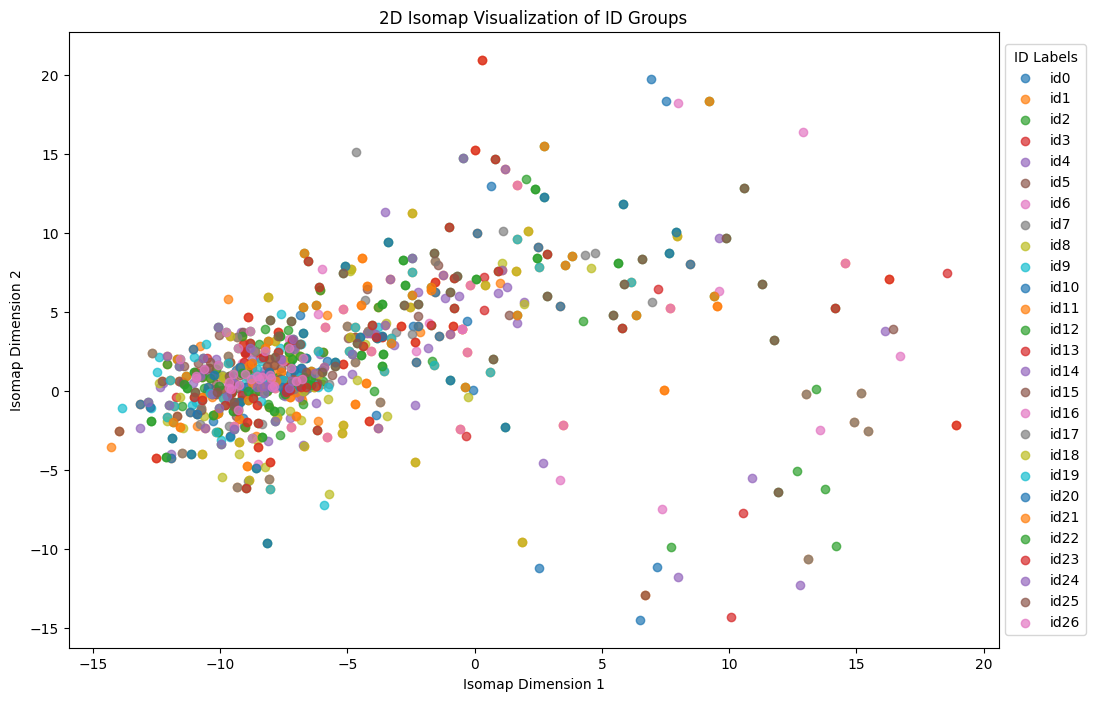

In [6]:
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt

# Extract the binary columns as the features
X = df.values

# Apply Isomap to reduce the dimensionality to 2 dimensions
isomap = Isomap(n_components=2)
X_transformed = isomap.fit_transform(X)

# Define colors and labels for visualization
plt.figure(figsize=(12, 8))

# Scatter plot with a unique color and label for each id
for i in range(27):
    mask = df[f'id{i}'].values  # Mask for each specific ID group
    plt.scatter(X_transformed[mask, 0], X_transformed[mask, 1], label=f'id{i}', alpha=0.7)

# Adding plot labels and legend
plt.title("2D Isomap Visualization of ID Groups")
plt.xlabel("Isomap Dimension 1")
plt.ylabel("Isomap Dimension 2")
plt.legend(title="ID Labels", loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import numpy as np

# Extract only the binary columns for the ids
binary_columns = df.columns[df.columns.str.startswith('id')]
binary_data = df[binary_columns].astype(int)

# Apply MDS to reduce dimensions to 2D
mds = MDS(n_components=2, random_state=42)
mds_transformed = mds.fit_transform(binary_data)

# Plot the results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(mds_transformed[:, 0], mds_transformed[:, 1], c=np.argmax(binary_data.values, axis=1), cmap='tab20', s=100)

# Add labels for each point based on id
for i, label in enumerate(binary_columns[np.argmax(binary_data.values, axis=1)]):
    plt.text(mds_transformed[i, 0], mds_transformed[i, 1], label, ha='right', fontsize=8)

# Add color bar and labels
plt.colorbar(scatter, ticks=range(27), label="ID Group")
plt.title("2D MDS Visualization of Binary ID Dataset")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Extract the binary columns (id0 to id26) for PCA
X = df.values
labels = df.columns

# Apply PCA to reduce the dimensionality to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the results in a 2D plot
plt.figure(figsize=(10, 7))
for i in range(27):
    plt.scatter(X_pca[df[f'id{i}'], 0], X_pca[df[f'id{i}'], 1], label=labels[i], alpha=0.6)

# Add labels and title to the plot
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D Visualization of Binary ID Data (PCA)")
plt.legend(loc='best', title="ID Groups")
plt.show()

### SVMs

For each id, split data for train valid test 70/15/15
Train aq group of SVMs with various kernels and other hyperparameters